In [1]:
import openpyxl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster
from IPython.display import IFrame
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
from math import radians, sin, cos, sqrt, atan2
import branca

In [2]:
# Load the Excel files into Pandas DataFrames
gis_weather_station = pd.read_csv('./data/gis_weatherstation_shape_2024_10_04.csv')
station_summary_snapshot = pd.read_csv('./data/src_wings_meteorology_station_summary_snapshot_2023_08_02.csv')
windspeed_snapshot = pd.read_csv('./data/src_wings_meteorology_windspeed_snapshot_2023_08_02.csv')

src_vri_snapshot = pd.read_csv('./data/src_vri_snapshot_2024_03_20.csv')
nam = pd.read_csv('./data/nam.csv')

In [3]:
def create_point(row):
    return Point(row['longitude'], row['latitude'])

def haversine_distance(point1: Point, point2: Point) -> float:
    R = 6371.0
    lon1, lat1 = point1.x, point1.y
    lon2, lat2 = point2.x, point2.y
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = sin(delta_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(delta_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def plot_histogram(data, column, bins=30, title=None, xlabel=None, ylabel="Frequency", color="blue"):
    """
    Plots a histogram for a specified column in the DataFrame.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name to plot the histogram for.
        bins (int): Number of bins for the histogram. Default is 30.
        title (str): The title of the histogram. Default is None.
        xlabel (str): The label for the x-axis. Default is the column name.
        ylabel (str): The label for the y-axis. Default is "Frequency".
        color (str): The color of the bars in the histogram. Default is "blue".
    """
    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")

    plt.figure(figsize=(10, 6))
    plt.hist(data[column], bins=bins, color=color, edgecolor="black", alpha=0.7)
    plt.title(title if title else f"Histogram of {column}", fontsize=14)
    plt.xlabel(xlabel if xlabel else column, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [4]:
gis_weather_station = gis_weather_station.drop_duplicates(subset=['weatherstationcode'], keep='first')
station_summary_snapshot = station_summary_snapshot.drop_duplicates(subset=['station'], keep='first')
windspeed_snapshot = windspeed_snapshot[(windspeed_snapshot['wind_speed'] < max(windspeed_snapshot['wind_speed']))]

weather_station_summary = gis_weather_station.merge(station_summary_snapshot, left_on='weatherstationcode', right_on='station',
                                                   how='inner').drop(columns=['station'])

weather_station_wind_speed = weather_station_summary.merge(windspeed_snapshot, left_on='weatherstationcode', right_on='station', 
                                                         how='inner').drop(columns=['station'])

In [5]:
weather_station_summary['geometry'] = weather_station_summary['shape'].apply(wkt.loads)
weather_station_summary_gpd = gpd.GeoDataFrame(weather_station_summary, geometry='geometry', crs=f"EPSG:{weather_station_summary['shape_srid'][0]}")

weather_station_wind_speed['geometry'] = weather_station_wind_speed['shape'].apply(wkt.loads)
weather_station_wind_speed_gpd = gpd.GeoDataFrame(weather_station_wind_speed, geometry='geometry', crs=f"EPSG:{weather_station_wind_speed['shape_srid'][0]}")

src_vri_snapshot['geometry'] = src_vri_snapshot['shape'].apply(wkt.loads)
src_vri_snapshot_gpd = gpd.GeoDataFrame(src_vri_snapshot, geometry='geometry', crs=f"EPSG:{src_vri_snapshot['shape_srid'][0]}")

nam_crs = src_vri_snapshot['shape_srid'][0]

nam['geometry'] = nam.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
nam_gpd = gpd.GeoDataFrame(nam, geometry='geometry', crs=nam_crs)

print(f"Weather Station CRS:    {weather_station_summary_gpd.crs}")
print(f"Wind Speed CRS:         {weather_station_wind_speed_gpd.crs}")
print(f"VRI Polygon CRS:        {src_vri_snapshot_gpd.crs}")
print(f"NAM CRS:                {nam_gpd.crs}")

Weather Station CRS:    EPSG:4431
Wind Speed CRS:         EPSG:4431
VRI Polygon CRS:        EPSG:4326
NAM CRS:                EPSG:4326


In [6]:
# Convert CRS to ESPG:4326
weather_station_summary_gpd = weather_station_summary_gpd.to_crs(src_vri_snapshot_gpd.crs)
weather_station_wind_speed_gpd = weather_station_wind_speed_gpd.to_crs(src_vri_snapshot_gpd.crs)

print(f"Weather Station CRS:    {weather_station_summary_gpd.crs}")
print(f"Wind Speed CRS:         {weather_station_wind_speed_gpd.crs}")
print(f"VRI Polygon CRS:        {src_vri_snapshot_gpd.crs}")
print(f"NAM CRS:                {nam_gpd.crs}")

Weather Station CRS:    EPSG:4326
Wind Speed CRS:         EPSG:4326
VRI Polygon CRS:        EPSG:4326
NAM CRS:                EPSG:4326


In [7]:
nam_vri_gpd = gpd.sjoin(nam_gpd, src_vri_snapshot_gpd, how='right', predicate='within')
nam_vri_gpd['NAM_geometry'] = nam_vri_gpd.apply(create_point, axis=1)
nam_vri_gpd = nam_vri_gpd.reset_index().drop(columns=['index', 'index_left'])

nam_vri_wind_speed_gpd = gpd.sjoin(weather_station_wind_speed_gpd, nam_vri_gpd, how='inner', predicate='within')
nam_vri_wind_speed_gpd = nam_vri_wind_speed_gpd.reset_index().drop(columns=['index', 'index_right'])
nam_vri_wind_speed_gpd.columns

Index(['objectid', 'weatherstationcode', 'weatherstationname', 'scadartuid',
       'structureid_left', 'nwszone', 'district_left', 'thomasbrospagegrid',
       'constructionstatus', 'creationuser', 'datecreated', 'datemodified',
       'lastuser', 'structureguid', 'symbolrotation', 'latitude_left',
       'longitude_left', 'elevation', 'twinguid', 'hftd_left', 'zone1idc_left',
       'hftdidc_left', 'gdb_geomattr_data', 'globalid_left', 'shape_left',
       'shape_srid_left', 'snapshot_date_x', 'vri', 'alert', 'max_gust',
       '99th', '95th', 'snapshot_date_y', 'date_left', 'wind_speed',
       'snapshot_date_left', 'geometry', 'latitude_right', 'longitude_right',
       'date_right', 'average_wind_speed', 'name', 'tessellate', 'extrude',
       'visibility', 'globalid_right', 'anemometer', 'anemometercode',
       'circuit', 'district_right', 'secdevice', 'structureid_right', 'tlid',
       'gust_99pct', 'gust_95pct', 'gust_max', 'vri_risk', 'loaddate',
       'county', 'hftd_right

In [8]:
nam_vri_wind_speed_gpd = nam_vri_wind_speed_gpd.rename(columns={
    'date_left' : 'wind_speed_date',
    'date_right': 'nam_date',
    'wind_speed': 'station_wind_speed',
    'average_wind_speed' : 'NAM_wind_speed',
    'shape_right': 'polygon_shape',
})

nam_vri_wind_speed_gpd['nam_date'] = pd.to_datetime(nam_vri_wind_speed_gpd['nam_date']).dt.strftime('%m/%d/%Y')

filtered_nam_vri_wind_speed_gpd = nam_vri_wind_speed_gpd[nam_vri_wind_speed_gpd['wind_speed_date'] == nam_vri_wind_speed_gpd['nam_date']].copy()
filtered_nam_vri_wind_speed_gpd['station_geometry'] = filtered_nam_vri_wind_speed_gpd['geometry']
filtered_nam_vri_wind_speed_gpd['polygon_geometry'] = filtered_nam_vri_wind_speed_gpd['polygon_shape'].apply(wkt.loads)
filtered_nam_vri_wind_speed_gpd['distance_from_station_km'] = filtered_nam_vri_wind_speed_gpd.apply(
    lambda row: haversine_distance(row['station_geometry'], row['NAM_geometry']), axis=1
)
filtered_nam_vri_wind_speed_gpd = filtered_nam_vri_wind_speed_gpd.reset_index().drop(columns=['index'])
filtered_nam_vri_wind_speed_gpd.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid_left,nwszone,district_left,thomasbrospagegrid,constructionstatus,creationuser,...,globalid_1,shape_length,shape_area,polygon_shape,shape_srid_right,snapshot_date_right,NAM_geometry,station_geometry,polygon_geometry,distance_from_station_km
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32819 33.14228),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",0.557226
1,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.31195 33.14219),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",1.516308
2,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32809 33.15589),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",2.063870
3,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.31183 33.15581),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",2.500861
4,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.31174 33.16941),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",3.843664


In [11]:
filtered_nam_vri_wind_speed_gpd.columns

Index(['objectid', 'weatherstationcode', 'weatherstationname', 'scadartuid',
       'structureid_left', 'nwszone', 'district_left', 'thomasbrospagegrid',
       'constructionstatus', 'creationuser', 'datecreated', 'datemodified',
       'lastuser', 'structureguid', 'symbolrotation', 'latitude_left',
       'longitude_left', 'elevation', 'twinguid', 'hftd_left', 'zone1idc_left',
       'hftdidc_left', 'gdb_geomattr_data', 'globalid_left', 'shape_left',
       'shape_srid_left', 'snapshot_date_x', 'vri', 'alert', 'max_gust',
       '99th', '95th', 'snapshot_date_y', 'wind_speed_date',
       'station_wind_speed', 'snapshot_date_left', 'geometry',
       'latitude_right', 'longitude_right', 'nam_date', 'NAM_wind_speed',
       'name', 'tessellate', 'extrude', 'visibility', 'globalid_right',
       'anemometer', 'anemometercode', 'circuit', 'district_right',
       'secdevice', 'structureid_right', 'tlid', 'gust_99pct', 'gust_95pct',
       'gust_max', 'vri_risk', 'loaddate', 'county', 'hf


Summary Statistics Comparison:
       NAM_wind_speed  station_wind_speed
count   102832.000000       102832.000000
mean        11.264387           20.569035
std          7.701748            8.596926
min          0.723270            3.000000
25%          5.456525           14.000000
50%          8.772444           18.000000
75%         15.351503           25.000000
max         56.089860           91.000000


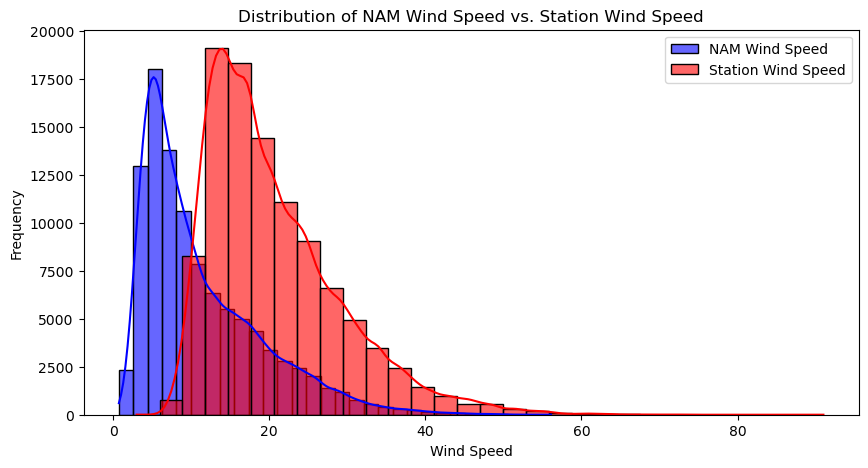

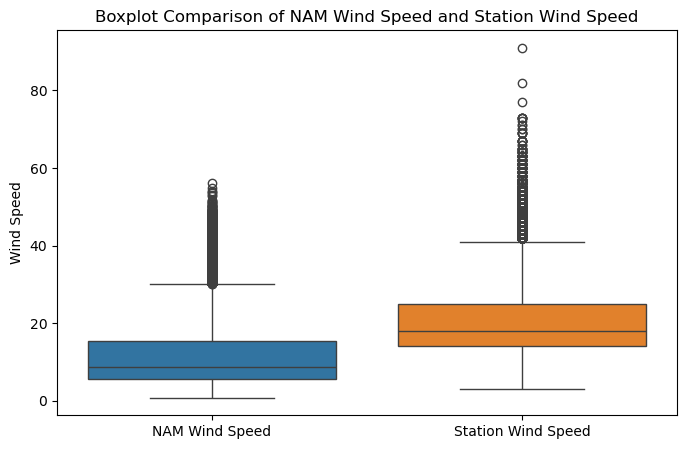

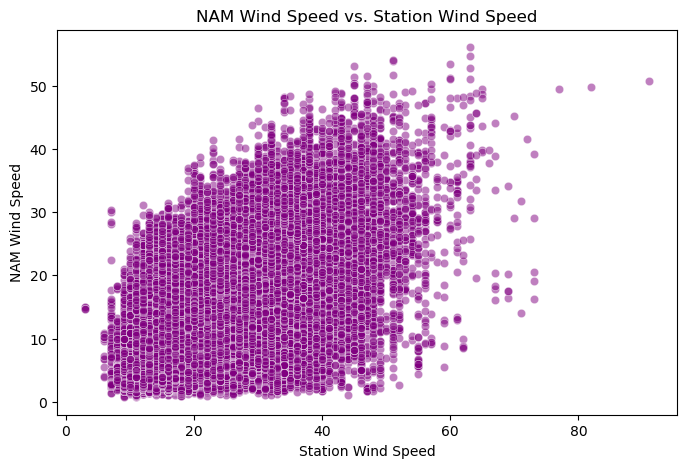


Correlation Between NAM Wind Speed and Station Wind Speed:
                    NAM_wind_speed  station_wind_speed
NAM_wind_speed            1.000000            0.583318
station_wind_speed        0.583318            1.000000


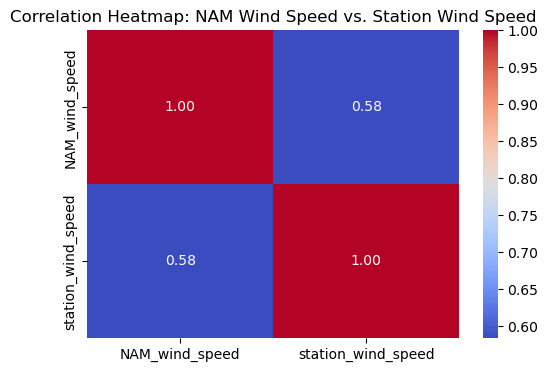

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure both wind speed columns are numeric
filtered_nam_vri_wind_speed_gpd["station_wind_speed"] = pd.to_numeric(
    filtered_nam_vri_wind_speed_gpd["station_wind_speed"], errors="coerce"
)
filtered_nam_vri_wind_speed_gpd["NAM_wind_speed"] = pd.to_numeric(
    filtered_nam_vri_wind_speed_gpd["NAM_wind_speed"], errors="coerce"
)

# Drop rows with NaN values in both columns
filtered_nam_vri_wind_speed_gpd = filtered_nam_vri_wind_speed_gpd.dropna(subset=["NAM_wind_speed", "station_wind_speed"])

# Display summary statistics for both columns
print("\nSummary Statistics Comparison:")
print(filtered_nam_vri_wind_speed_gpd[["NAM_wind_speed", "station_wind_speed"]].describe())

# Histogram comparison
plt.figure(figsize=(10, 5))
sns.histplot(filtered_nam_vri_wind_speed_gpd["NAM_wind_speed"], bins=30, kde=True, color='blue', label="NAM Wind Speed", alpha=0.6)
sns.histplot(filtered_nam_vri_wind_speed_gpd["station_wind_speed"], bins=30, kde=True, color='red', label="Station Wind Speed", alpha=0.6)
plt.title("Distribution of NAM Wind Speed vs. Station Wind Speed")
plt.xlabel("Wind Speed")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Boxplot comparison
plt.figure(figsize=(8, 5))
sns.boxplot(data=filtered_nam_vri_wind_speed_gpd[["NAM_wind_speed", "station_wind_speed"]])
plt.title("Boxplot Comparison of NAM Wind Speed and Station Wind Speed")
plt.ylabel("Wind Speed")
plt.xticks(ticks=[0, 1], labels=["NAM Wind Speed", "Station Wind Speed"])
plt.show()

# Scatter plot to visualize correlation
plt.figure(figsize=(8, 5))
sns.scatterplot(x=filtered_nam_vri_wind_speed_gpd["station_wind_speed"], 
                y=filtered_nam_vri_wind_speed_gpd["NAM_wind_speed"], 
                alpha=0.5, color='purple')
plt.title("NAM Wind Speed vs. Station Wind Speed")
plt.xlabel("Station Wind Speed")
plt.ylabel("NAM Wind Speed")
plt.show()

# Compute and display correlation
correlation = filtered_nam_vri_wind_speed_gpd[["NAM_wind_speed", "station_wind_speed"]].corr()
print("\nCorrelation Between NAM Wind Speed and Station Wind Speed:")
print(correlation)

# Heatmap of correlation
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: NAM Wind Speed vs. Station Wind Speed")
plt.show()


In [11]:
grouped_columns = ['NAM_geometry', 'station_geometry', 'polygon_geometry', 'name']
filtered_nam_vri_wind_speed_gpd_grouped = filtered_nam_vri_wind_speed_gpd.groupby(grouped_columns, sort=False)

# Mean Absolute Error
def calculate_mae(group):
    abs_error = abs(group['NAM_wind_speed'] - group['station_wind_speed'])
    return abs_error.mean()

# Mean Squared Error
def calculate_mse(group):
    squared_error = (group['NAM_wind_speed'] - group['station_wind_speed']) ** 2
    return squared_error.mean()

# Normalized Mean Absolute Error
def calculate_nmae(group):
    group['abs_error'] = abs(group['NAM_wind_speed'] - group['station_wind_speed'])
    mae = group['abs_error'].mean()
    actual_range = group['station_wind_speed'].max() - group['station_wind_speed'].min()
    nmae = mae / actual_range if actual_range != 0 else None
    return nmae

# Normalized Mean Squared Error
def calculate_nmse(group):
    group['squared_error'] = (group['NAM_wind_speed'] - group['station_wind_speed']) ** 2
    mse = group['squared_error'].mean()
    actual_range = group['station_wind_speed'].max() - group['station_wind_speed'].min()
    nmse = mse / actual_range if actual_range != 0 else None
    return nmse

# Sigmoid-Damped Distance Error
def calculate_sdwe(group):
    abs_error = abs(group['NAM_wind_speed'] - group['station_wind_speed'])
    distance = group['distance_from_station_km'].iloc[0]
    sigmoid_weight = 1 / (1 + np.exp(-(distance - d0)/tau))
    return (abs_error * sigmoid_weight).mean()

# Distance-Weighted Absolute Error (DWAE)
def calculate_dwae(group):
    abs_error = abs(group['NAM_wind_speed'] - group['station_wind_speed'])
    distance = group['distance_from_station_km'].iloc[0]
    return (abs_error * distance).mean()

d0 = filtered_nam_vri_wind_speed_gpd['distance_from_station_km'].median()
tau = filtered_nam_vri_wind_speed_gpd['distance_from_station_km'].std()

mae = filtered_nam_vri_wind_speed_gpd_grouped.apply(calculate_mae, include_groups=False).reset_index(name='MAE')
mse = filtered_nam_vri_wind_speed_gpd_grouped.apply(calculate_mse, include_groups=False).reset_index(name='MSE')
nmae = filtered_nam_vri_wind_speed_gpd_grouped.apply(calculate_nmae, include_groups=False).reset_index(name='NMAE')
nmse = filtered_nam_vri_wind_speed_gpd_grouped.apply(calculate_nmse, include_groups=False).reset_index(name='NMSE')
dwae = filtered_nam_vri_wind_speed_gpd_grouped.apply(calculate_dwae, include_groups=False).reset_index(name='DWAE')
sdwe = filtered_nam_vri_wind_speed_gpd_grouped.apply(calculate_sdwe, include_groups=False).reset_index(name='SDWE')

errors = (
    mae
    .merge(mse, on=grouped_columns, how='inner')
    .merge(nmae, on=grouped_columns, how='inner')
    .merge(nmse, on=grouped_columns, how='inner')
    .merge(dwae, on=grouped_columns, how='inner')
    .merge(sdwe, on=grouped_columns, how='inner')
)

errors['distance_from_station_km'] = errors.apply(
    lambda row: haversine_distance(row['station_geometry'], row['NAM_geometry']), axis=1
)

errors.head()

,NAM_geometry,station_geometry,polygon_geometry,name,MAE,MSE,NMAE,NMSE,DWAE,SDWE,distance_from_station_km
0,POINT (-117.32819 33.14228),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.870465,48.897510,0.234819,1.955900,3.271176,2.379555,0.557226
1,POINT (-117.31195 33.14219),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.858967,48.963066,0.234359,1.958523,8.884001,2.600711,1.516308
2,POINT (-117.32809 33.15589),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.876088,48.885729,0.235044,1.955429,12.127479,2.739599,2.063870
3,POINT (-117.31183 33.15581),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.906324,49.278501,0.236253,1.971140,14.770896,2.859616,2.500861
4,POINT (-117.31174 33.16941),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.970476,49.542936,0.238819,1.981717,22.948506,3.220017,3.843664


In [12]:
errors

,NAM_geometry,station_geometry,polygon_geometry,name,MAE,MSE,NMAE,NMSE,DWAE,SDWE,distance_from_station_km
0,POINT (-117.32819 33.14228),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.870465,48.897510,0.234819,1.955900,3.271176,2.379555,0.557226
1,POINT (-117.31195 33.14219),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.858967,48.963066,0.234359,1.958523,8.884001,2.600711,1.516308
2,POINT (-117.32809 33.15589),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.876088,48.885729,0.235044,1.955429,12.127479,2.739599,2.063870
3,POINT (-117.31183 33.15581),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.906324,49.278501,0.236253,1.971140,14.770896,2.859616,2.500861
4,POINT (-117.31174 33.16941),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.970476,49.542936,0.238819,1.981717,22.948506,3.220017,3.843664
...,...,...,...,...,...,...,...,...,...,...,...
1137,POINT (-116.8421 33.02989),POINT (-116.871 33.01565),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",Creelman_VRI,7.328857,81.920690,0.229027,2.560022,22.902926,3.736516,3.125034
1138,POINT (-116.85815 33.04365),POINT (-116.871 33.01565),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",Creelman_VRI,7.092730,77.721502,0.221648,2.428797,23.658617,3.677531,3.335615
1139,POINT (-116.84193 33.0435),POINT (-116.871 33.01565),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",Creelman_VRI,7.003253,76.929296,0.218852,2.404041,28.816877,3.854506,4.114784
1140,POINT (-116.98926 32.93591),POINT (-116.871 33.01565),"MULTIPOLYGON Z (((-116.871922 33.01855 0, -116...",TL6917_VRI,14.460807,249.979961,0.451900,7.811874,204.665001,12.503259,14.153083


In [13]:
errors.describe()

,MAE,MSE,NMAE,NMSE,DWAE,SDWE,distance_from_station_km
count,1142.000000,1142.000000,1137.000000,1137.000000,1142.000000,1142.000000,1142.000000
mean,10.371692,156.326481,0.347895,4.917016,59.125508,5.811902,4.961056
std,4.086322,135.361941,0.196052,3.949746,130.184127,3.628766,6.661794
min,4.614064,26.149892,0.140141,1.397648,0.355772,1.813195,0.052800
25%,7.489458,74.743523,0.269903,2.913829,14.247282,3.853223,1.555330
50%,9.450922,118.416777,0.322941,4.071099,27.225984,5.029553,2.839527
75%,12.200283,189.733976,0.390749,5.560366,51.986035,6.358847,5.264347
max,37.690099,1491.629536,4.582698,53.494454,1754.130646,37.247743,51.902432


In [14]:
errors['NAM_geometry'].nunique

<bound method IndexOpsMixin.nunique of 0       POINT (-117.32819 33.14228)
1       POINT (-117.31195 33.14219)
2       POINT (-117.32809 33.15589)
3       POINT (-117.31183 33.15581)
4       POINT (-117.31174 33.16941)
                   ...             
1137     POINT (-116.8421 33.02989)
1138    POINT (-116.85815 33.04365)
1139     POINT (-116.84193 33.0435)
1140    POINT (-116.98926 32.93591)
1141    POINT (-116.89148 32.97591)
Name: NAM_geometry, Length: 1142, dtype: geometry>

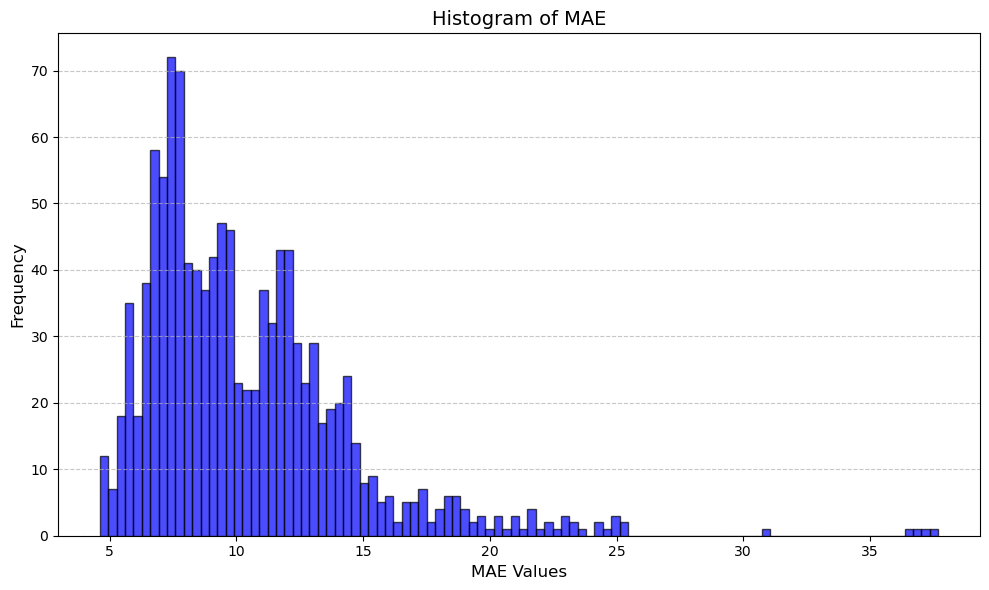

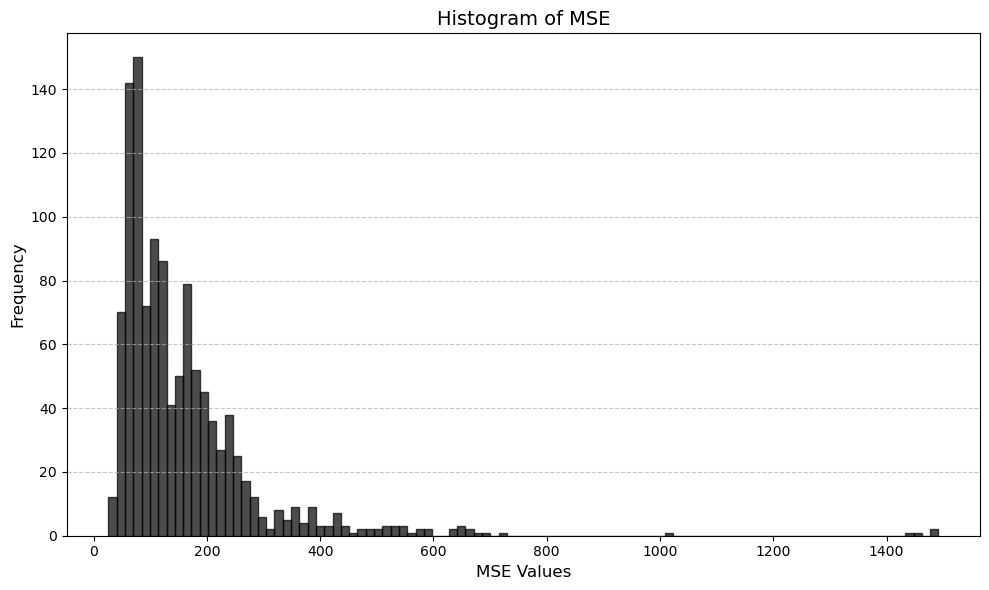

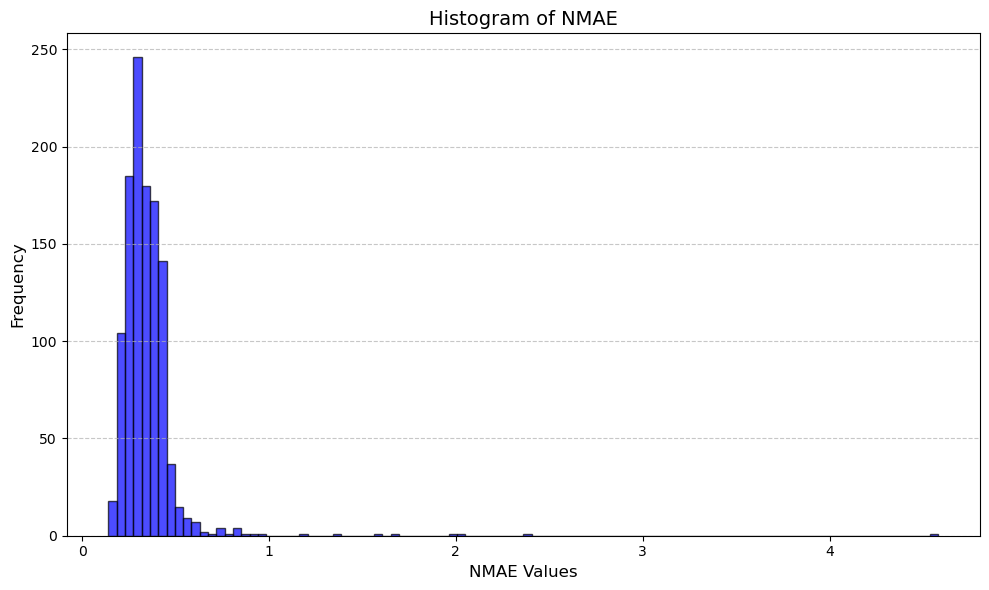

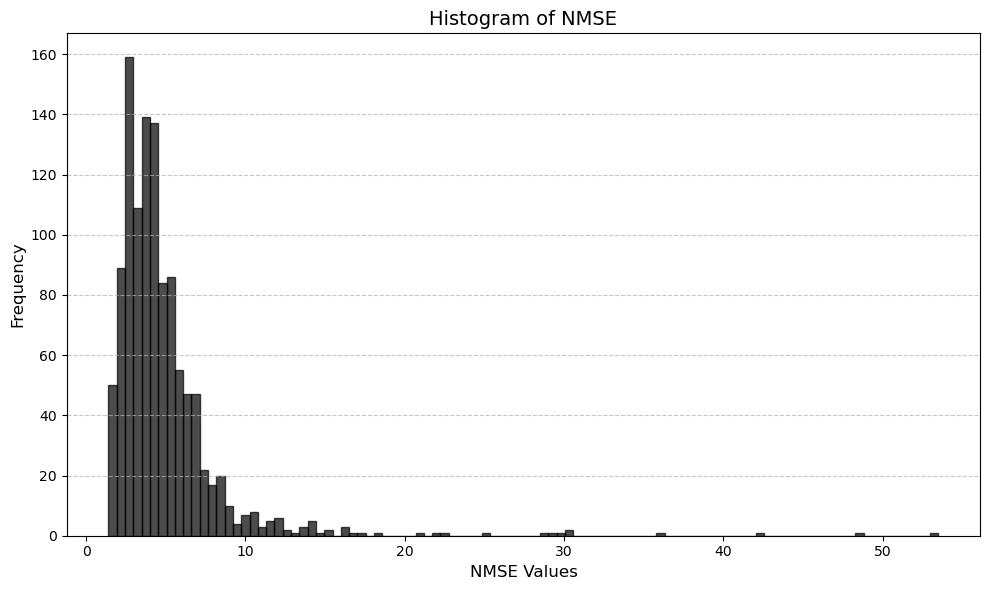

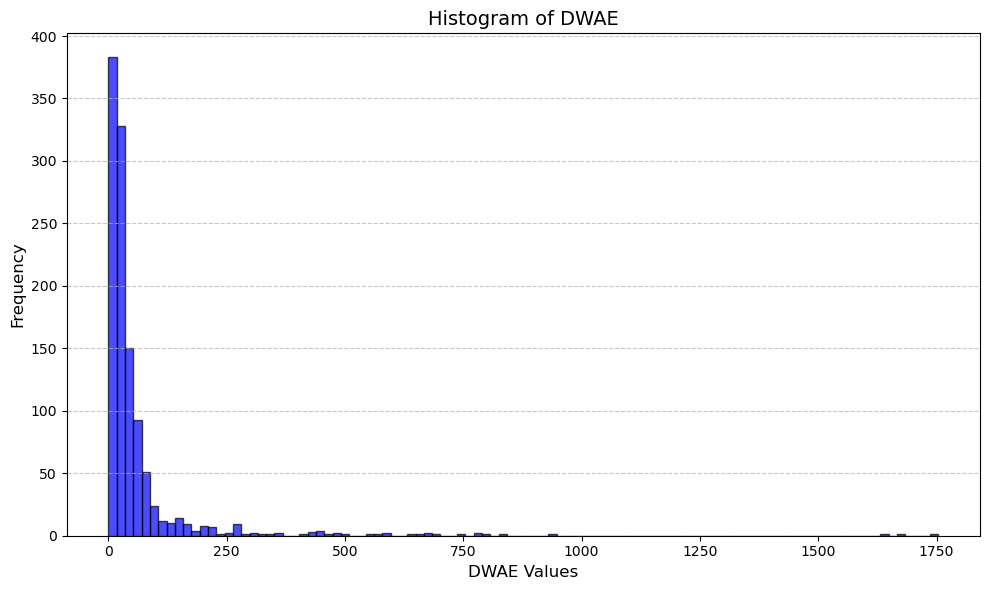

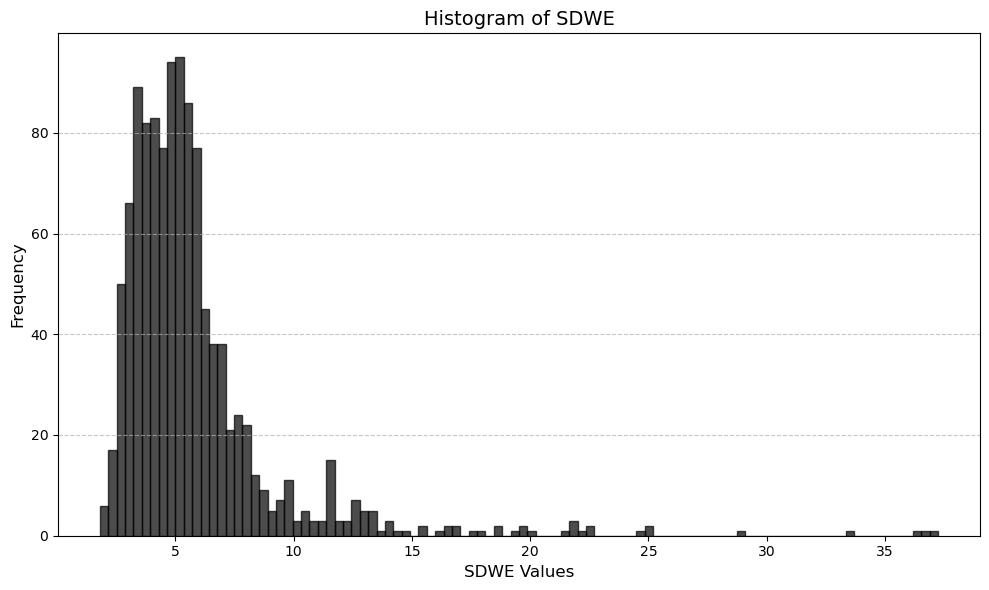

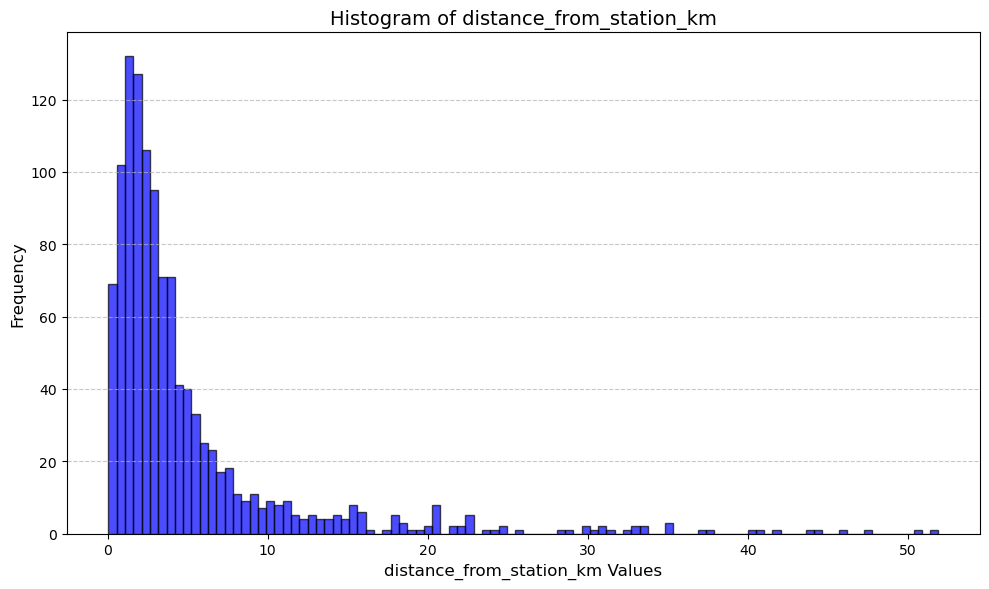

In [15]:
columns = list(errors.columns)[4:]

for i, col in enumerate(columns):
    color = "blue" if i % 2 == 0  else "black"
    
    plot_histogram(
        data=errors,
        column=col,
        bins=100,
        title=f"Histogram of {col}",
        xlabel=f"{col} Values",
        color=color
    )

In [16]:
# Initialize the map centering at San Diego City
m = folium.Map(location=[32.7157, -117.1611], zoom_start=10, tiles="OpenStreetMap")

# NAM Coordinates
NAM_coordinates = folium.FeatureGroup(name='NAM_coordinates')

# Normalize the MAE values to ensure colors are mapped to a range
min_mae, max_mae = errors["MAE"].min(), errors["MAE"].max()

# Define colormap for yellow to red
colormap = branca.colormap.LinearColormap(['#FFFF00', '#FF0000'], vmin=min_mae, vmax=max_mae)

# Plot each point on the map with constant opacity and color based on MAE
for _, row in errors.iterrows():
    latitude, longitude = row["NAM_geometry"].y, row["NAM_geometry"].x
    
    # Color based on the MAE value using the colormap
    color = colormap(row["MAE"])
    
    folium.CircleMarker(
        location=(latitude, longitude),
        radius=3,
        color=color,
        fill=True,
        fill_color=color, 
        fill_opacity=0.9,  
        opacity=0.9,    
        tooltip=(f"MAE: {row['MAE']:.3f}<br>"
                 f"MSE: {row['MSE']:.3f}<br>"
                 f"NMAE: {row['NMAE']:.3f}<br>"
                 f"NMSE: {row['NMSE']:.3f}<br>"
                 f"DWAE: {row['DWAE']:.3f}<br>"
                 f"SDWE: {row['SDWE']:.3f}<br>"
                 f"Dist: {row['distance_from_station_km']:.3f}km<br>"
    )
    ).add_to(NAM_coordinates)

# Weather Station
weather_stations = folium.FeatureGroup(name='Weather Stations')

for idx, row in weather_station_summary_gpd.iterrows():
    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=4,
        color="green",
        fill=True,
        fill_color="green",
        fill_opacity=1,
        opacity=1,
        tooltip=(f"Station: {row['weatherstationname']}<br>")
    ).add_to(weather_stations)

# VRI Snapshot
vri_snapshot = folium.FeatureGroup(name='VRI Snapshot')

# Load simplified GeoJSON with tooltip
vri_tooltip = folium.GeoJsonTooltip(
    fields=["name", "vri_risk", "shape_area"],
    aliases=["Name:", "VRI Risk:", "Shape Area:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

# Load VRI GeoJSON
vri_map = folium.GeoJson(
    src_vri_snapshot_gpd,
    style_function=lambda x: {
        "fillColor": "#0059b3",
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.5
    },
    tooltip=vri_tooltip,
)
vri_map.add_to(vri_snapshot)

# Add feature groups to the map
vri_snapshot.add_to(m)
NAM_coordinates.add_to(m)
weather_stations.add_to(m)

# Add layer control to toggle feature groups
folium.LayerControl().add_to(m)

# Save the map
map_path = "san_diego_map_MAE.html"
m.save(map_path)

# Render the map in the notebook using IFrame
IFrame(map_path, width=700, height=500)


In [17]:
# Initialize the map centering at San Diego City
m = folium.Map(location=[32.7157, -117.1611], zoom_start=10, tiles="OpenStreetMap")

# NAM Coordinates
NAM_coordinates = folium.FeatureGroup(name='NAM_coordinates')

# Normalize the MAE values to ensure colors are mapped to a range
min_mae, max_mae = errors["SDWE"].min(), errors["SDWE"].max()

# Define colormap for yellow to red
colormap = branca.colormap.LinearColormap(['#FFFF00', '#FF0000'], vmin=min_mae, vmax=max_mae)

# Plot each point on the map with constant opacity and color based on MAE
for _, row in errors.iterrows():
    latitude, longitude = row["NAM_geometry"].y, row["NAM_geometry"].x
    
    # Color based on the MAE value using the colormap
    color = colormap(row["SDWE"])
    
    folium.CircleMarker(
        location=(latitude, longitude),
        radius=3,
        color=color,
        fill=True,
        fill_color=color, 
        fill_opacity=0.9,  
        opacity=0.9,    
        tooltip=(f"MAE: {row['MAE']:.3f}<br>"
                 f"MSE: {row['MSE']:.3f}<br>"
                 f"NMAE: {row['NMAE']:.3f}<br>"
                 f"NMSE: {row['NMSE']:.3f}<br>"
                 f"DWAE: {row['DWAE']:.3f}<br>"
                 f"SDWE: {row['SDWE']:.3f}<br>"
                 f"Dist: {row['distance_from_station_km']:.3f}km<br>"
    )
    ).add_to(NAM_coordinates)

# Weather Station
weather_stations = folium.FeatureGroup(name='Weather Stations')

for idx, row in weather_station_summary_gpd.iterrows():
    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=4,
        color="green",
        fill=True,
        fill_color="green",
        fill_opacity=1,
        opacity=1,
        tooltip=(f"Station: {row['weatherstationname']}<br>")
    ).add_to(weather_stations)

# VRI Snapshot
vri_snapshot = folium.FeatureGroup(name='VRI Snapshot')

# Load simplified GeoJSON with tooltip
vri_tooltip = folium.GeoJsonTooltip(
    fields=["name", "vri_risk", "shape_area"],
    aliases=["Name:", "VRI Risk:", "Shape Area:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

# Load VRI GeoJSON
vri_map = folium.GeoJson(
    src_vri_snapshot_gpd,
    style_function=lambda x: {
        "fillColor": "#0059b3",
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.5
    },
    tooltip=vri_tooltip,
)
vri_map.add_to(vri_snapshot)

# Add feature groups to the map
vri_snapshot.add_to(m)
NAM_coordinates.add_to(m)
weather_stations.add_to(m)

# Add layer control to toggle feature groups
folium.LayerControl().add_to(m)

# Save the map
map_path = "san_diego_map_MAE.html"
m.save(map_path)

# Render the map in the notebook using IFrame
IFrame(map_path, width=700, height=500)


In [18]:
nam_vri_wind_speed_gpd = nam_vri_wind_speed_gpd.rename(columns={
    'date_left' : 'wind_speed_date',
    'date_right': 'nam_date',
    'wind_speed': 'station_wind_speed',
    'average_wind_speed' : 'NAM_wind_speed',
    'shape_right': 'polygon_shape',
})

nam_vri_wind_speed_gpd['nam_date'] = pd.to_datetime(nam_vri_wind_speed_gpd['nam_date']).dt.strftime('%m/%d/%Y')

filtered_nam_vri_wind_speed_gpd = nam_vri_wind_speed_gpd[nam_vri_wind_speed_gpd['wind_speed_date'] == nam_vri_wind_speed_gpd['nam_date']].copy()
filtered_nam_vri_wind_speed_gpd['station_geometry'] = filtered_nam_vri_wind_speed_gpd['geometry']
filtered_nam_vri_wind_speed_gpd['polygon_geometry'] = filtered_nam_vri_wind_speed_gpd['polygon_shape'].apply(wkt.loads)
filtered_nam_vri_wind_speed_gpd['distance_from_station_km'] = filtered_nam_vri_wind_speed_gpd.apply(
    lambda row: haversine_distance(row['station_geometry'], row['NAM_geometry']), axis=1
)

pd.set_option('display.max_columns', None)
filtered_nam_vri_wind_speed_gpd = filtered_nam_vri_wind_speed_gpd.reset_index().drop(columns=['index'])
filtered_nam_vri_wind_speed_gpd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
filtered_nam_vri_wind_speed_gpd.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid_left,nwszone,district_left,thomasbrospagegrid,constructionstatus,creationuser,datecreated,datemodified,lastuser,structureguid,symbolrotation,latitude_left,longitude_left,elevation,twinguid,hftd_left,zone1idc_left,hftdidc_left,gdb_geomattr_data,globalid_left,shape_left,shape_srid_left,snapshot_date_x,vri,alert,max_gust,99th,95th,snapshot_date_y,wind_speed_date,station_wind_speed,snapshot_date_left,geometry,latitude_right,longitude_right,nam_date,NAM_wind_speed,name,tessellate,extrude,visibility,globalid_right,anemometer,anemometercode,circuit,district_right,secdevice,structureid_right,tlid,gust_99pct,gust_95pct,gust_max,vri_risk,loaddate,county,hftd_right,hftdidc_right,zone1idc_right,globalid_1,shape_length,shape_area,polygon_shape,shape_srid_right,snapshot_date_right,NAM_geometry,station_geometry,polygon_geometry,distance_from_station_km
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,12/10/2012,11.0,8/2/2023,POINT (-117.32717 33.13735),33.142284,-117.328186,12/10/2012,7.714246,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32819 33.14228),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",0.557226
1,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,12/10/2012,11.0,8/2/2023,POINT (-117.32717 33.13735),33.142193,-117.311950,12/10/2012,7.851097,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.31195 33.14219),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",1.516308
2,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,12/10/2012,11.0,8/2/2023,POINT (-117.32717 33.13735),33.155890,-117.328094,12/10/2012,7.401690,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32809 33.15589),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",2.063870
3,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,12/10/2012,11.0,8/2/2023,POINT (-117.32717 33.13735),33.155807,-117.311830,12/10/2012,7.464030,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POIN

In [20]:
NAM_points = filtered_nam_vri_wind_speed_gpd[['NAM_geometry', 'polygon_geometry', 'weatherstationcode', 'station_geometry', 'geometry']]
NAM_points = NAM_points.drop_duplicates()
NAM_points

,NAM_geometry,polygon_geometry,weatherstationcode,station_geometry,geometry
0,POINT (-117.32819 33.14228),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735)
1,POINT (-117.31195 33.14219),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735)
2,POINT (-117.32809 33.15589),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735)
3,POINT (-117.31183 33.15581),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735)
4,POINT (-117.31174 33.16941),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735)
...,...,...,...,...,...
101099,POINT (-116.8421 33.02989),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",CLM,POINT (-116.871 33.01565),POINT (-116.871 33.01565)
101100,POINT (-116.85815 33.04365),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",CLM,POINT (-116.871 33.01565),POINT (-116.871 33.01565)
101101,POINT (-116.84193 33.0435),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",CLM,POINT (-116.871 33.01565),POINT (-116.871 33.01565)
101102,POINT (-116.98926 32.93591),"MULTIPOLYGON Z (((-116.871922 33.01855 0, -116...",CLM,POINT (-116.871 33.01565),POINT (-116.871 33.01565)


In [21]:
current_point = NAM_points['NAM_geometry'][0]
station_geometry = NAM_points['station_geometry'][0]
haversine_distance(current_point, station_geometry)

0.5572259664698805

In [22]:
# Calculate the nearest station excluding the station in the same row based on weatherstationcode
nearest_stations = []
nearest_station_codes = []
nearest_station_distances = []

for idx, row in NAM_points.iterrows():
    current_point = row["NAM_geometry"]
    current_station_code = row["weatherstationcode"]
    
    # Exclude the current row's station based on weatherstationcode
    other_stations = NAM_points[NAM_points["weatherstationcode"] != current_station_code]
    
    # Compute distances to all other stations and find the nearest
    min_distance = float("inf")
    nearest_station = None
    nearest_station_code = None
    
    for _, other_row in other_stations.iterrows():
        station_geometry = other_row["station_geometry"] 
        station_code = other_row["weatherstationcode"]  # Get the station code
        
        distance = haversine_distance(current_point, station_geometry)
        if distance < min_distance:
            min_distance = distance
            nearest_station = station_geometry
            nearest_station_code = station_code
    
    nearest_stations.append(nearest_station)
    nearest_station_codes.append(nearest_station_code)
    nearest_station_distances.append(min_distance)

# Add results to the DataFrame
NAM_points["nearest_station_geometry"] = nearest_stations
NAM_points["nearest_weather_station_code"] = nearest_station_codes
NAM_points["nearest_station_distance_km"] = nearest_station_distances

In [23]:
other_stations

,NAM_geometry,polygon_geometry,weatherstationcode,station_geometry,geometry
0,POINT (-117.32819 33.14228),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735)
1,POINT (-117.31195 33.14219),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735)
2,POINT (-117.32809 33.15589),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735)
3,POINT (-117.31183 33.15581),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735)
4,POINT (-117.31174 33.16941),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735)
...,...,...,...,...,...
100278,POINT (-117.05017 33.30381),"MULTIPOLYGON Z (((-117.042606 33.293205 0, -11...",CGD,POINT (-117.01563 33.28465),POINT (-117.01563 33.28465)
100279,POINT (-117.03388 33.30368),"MULTIPOLYGON Z (((-117.042606 33.293205 0, -11...",CGD,POINT (-117.01563 33.28465),POINT (-117.01563 33.28465)
100280,POINT (-117.01761 33.30356),"MULTIPOLYGON Z (((-117.042606 33.293205 0, -11...",CGD,POINT (-117.01563 33.28465),POINT (-117.01563 33.28465)
100281,POINT (-117.08316 33.26323),"MULTIPOLYGON Z (((-116.965651 33.287406 0, -11...",CGD,POINT (-117.01563 33.28465),POINT (-117.01563 33.28465)


In [24]:
NAM_points.head()

,NAM_geometry,polygon_geometry,weatherstationcode,station_geometry,geometry,nearest_station_geometry,nearest_weather_station_code,nearest_station_distance_km
0,POINT (-117.32819 33.14228),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735),POINT (-117.2538930096666 33.205480261391735),VIS,9.858575
1,POINT (-117.31195 33.14219),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735),POINT (-117.2538930096666 33.205480261391735),VIS,8.872425
2,POINT (-117.32809 33.15589),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735),POINT (-117.2538930096666 33.205480261391735),VIS,8.836958
3,POINT (-117.31183 33.15581),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735),POINT (-117.2538930096666 33.205480261391735),VIS,7.718837
4,POINT (-117.31174 33.16941),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",CBD,POINT (-117.32717 33.13735),POINT (-117.32717 33.13735),POINT (-117.2538930096666 33.205480261391735),VIS,6.713198


In [25]:
NAM_points = NAM_points[['NAM_geometry', 'nearest_weather_station_code', 'nearest_station_distance_km']]
NAM_points.head()

,NAM_geometry,nearest_weather_station_code,nearest_station_distance_km
0,POINT (-117.32819 33.14228),VIS,9.858575
1,POINT (-117.31195 33.14219),VIS,8.872425
2,POINT (-117.32809 33.15589),VIS,8.836958
3,POINT (-117.31183 33.15581),VIS,7.718837
4,POINT (-117.31174 33.16941),VIS,6.713198


In [26]:


merged_nearest = filtered_nam_vri_wind_speed_gpd.merge(
    NAM_points, 
    how='inner', 
    left_on='NAM_geometry', 
    right_on='NAM_geometry'
)

                                 
merged_nearest.head()
                              
   

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid_left,nwszone,district_left,thomasbrospagegrid,constructionstatus,creationuser,datecreated,datemodified,lastuser,structureguid,symbolrotation,latitude_left,longitude_left,elevation,twinguid,hftd_left,zone1idc_left,hftdidc_left,gdb_geomattr_data,globalid_left,shape_left,shape_srid_left,snapshot_date_x,vri,alert,max_gust,99th,95th,snapshot_date_y,wind_speed_date,station_wind_speed,snapshot_date_left,geometry,latitude_right,longitude_right,nam_date,NAM_wind_speed,name,tessellate,extrude,visibility,globalid_right,anemometer,anemometercode,circuit,district_right,secdevice,structureid_right,tlid,gust_99pct,gust_95pct,gust_max,vri_risk,loaddate,county,hftd_right,hftdidc_right,zone1idc_right,globalid_1,shape_length,shape_area,polygon_shape,shape_srid_right,snapshot_date_right,NAM_geometry,station_geometry,polygon_geometry,distance_from_station_km,nearest_weather_station_code,nearest_station_distance_km
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,12/10/2012,11.0,8/2/2023,POINT (-117.32717 33.13735),33.142284,-117.328186,12/10/2012,7.714246,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32819 33.14228),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",0.557226,VIS,9.858575
1,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,12/10/2012,11.0,8/2/2023,POINT (-117.32717 33.13735),33.142193,-117.311950,12/10/2012,7.851097,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.31195 33.14219),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",1.516308,VIS,8.872425
2,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,12/10/2012,11.0,8/2/2023,POINT (-117.32717 33.13735),33.155890,-117.328094,12/10/2012,7.401690,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32809 33.15589),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",2.063870,VIS,8.836958
3,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,12/10/2012,11.0,8/2/2023,POINT (-117.32717 33.13735),33.155807,-117.311830,12/10/2012,7.464030,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38

In [27]:
weather_station_poly = merged_nearest.drop_duplicates(subset=['wind_speed_date', 'weatherstationcode'])[['weatherstationcode', 'wind_speed_date',
                                                                         'station_wind_speed', 'station_geometry' ,'polygon_geometry' ,'name']]
weather_station_poly.head()

,weatherstationcode,wind_speed_date,station_wind_speed,station_geometry,polygon_geometry,name
0,CBD,12/10/2012,11.0,POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI
9,CBD,12/19/2012,16.0,POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI
18,CBD,12/20/2012,17.0,POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI
27,CBD,12/25/2012,13.0,POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI
36,CBD,10/14/2013,15.0,POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI


In [28]:
pd.set_option('display.max_columns', None)
merged_nearest_windspeed = merged_nearest.merge(  
    weather_station_poly,
    how='inner', 
    left_on=['nearest_weather_station_code', 'wind_speed_date'],
    right_on=['weatherstationcode', 'wind_speed_date'])
merged_nearest_windspeed = merged_nearest_windspeed

merged_nearest_windspeed.columns

Index(['objectid', 'weatherstationcode_x', 'weatherstationname', 'scadartuid',
       'structureid_left', 'nwszone', 'district_left', 'thomasbrospagegrid',
       'constructionstatus', 'creationuser', 'datecreated', 'datemodified',
       'lastuser', 'structureguid', 'symbolrotation', 'latitude_left',
       'longitude_left', 'elevation', 'twinguid', 'hftd_left', 'zone1idc_left',
       'hftdidc_left', 'gdb_geomattr_data', 'globalid_left', 'shape_left',
       'shape_srid_left', 'snapshot_date_x', 'vri', 'alert', 'max_gust',
       '99th', '95th', 'snapshot_date_y', 'wind_speed_date',
       'station_wind_speed_x', 'snapshot_date_left', 'geometry',
       'latitude_right', 'longitude_right', 'nam_date', 'NAM_wind_speed',
       'name_x', 'tessellate', 'extrude', 'visibility', 'globalid_right',
       'anemometer', 'anemometercode', 'circuit', 'district_right',
       'secdevice', 'structureid_right', 'tlid', 'gust_99pct', 'gust_95pct',
       'gust_max', 'vri_risk', 'loaddate', 'county

In [29]:
merged_nearest_windspeed['distance_from_station_km_y'] = merged_nearest_windspeed.apply(
    lambda row: haversine_distance(row['station_geometry_y'], row['NAM_geometry']), axis=1
)
merged_nearest_windspeed.head()

,objectid,weatherstationcode_x,weatherstationname,scadartuid,structureid_left,nwszone,district_left,thomasbrospagegrid,constructionstatus,creationuser,datecreated,datemodified,lastuser,structureguid,symbolrotation,latitude_left,longitude_left,elevation,twinguid,hftd_left,zone1idc_left,hftdidc_left,gdb_geomattr_data,globalid_left,shape_left,shape_srid_left,snapshot_date_x,vri,alert,max_gust,99th,95th,snapshot_date_y,wind_speed_date,station_wind_speed_x,snapshot_date_left,geometry,latitude_right,longitude_right,nam_date,NAM_wind_speed,name_x,tessellate,extrude,visibility,globalid_right,anemometer,anemometercode,circuit,district_right,secdevice,structureid_right,tlid,gust_99pct,gust_95pct,gust_max,vri_risk,loaddate,county,hftd_right,hftdidc_right,zone1idc_right,globalid_1,shape_length,shape_area,polygon_shape,shape_srid_right,snapshot_date_right,NAM_geometry,station_geometry_x,polygon_geometry_x,distance_from_station_km,nearest_weather_station_code,nearest_station_distance_km,weatherstationcode_y,station_wind_speed_y,station_geometry_y,polygon_geometry_y,name_y,distance_from_station_km_y
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,11/12/2015,15.0,8/2/2023,POINT (-117.32717 33.13735),33.142284,-117.328186,11/12/2015,6.125546,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32819 33.14228),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",0.557226,VIS,9.858575,VIS,11.0,POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,9.858575
1,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,11/12/2015,15.0,8/2/2023,POINT (-117.32717 33.13735),33.142193,-117.311950,11/12/2015,6.103306,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.31195 33.14219),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",1.516308,VIS,8.872425,VIS,11.0,POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,8.872425
2,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,11/12/2015,15.0,8/2/2023,POINT (-117.32717 33.13735),33.155890,-117.328094,11/12/2015,5.944322,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32809 33.15589),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",2.063870,VIS,8.836958,VIS,11.0,POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,8.836958
3,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137

In [30]:
merged_nearest_windspeed.head()

,objectid,weatherstationcode_x,weatherstationname,scadartuid,structureid_left,nwszone,district_left,thomasbrospagegrid,constructionstatus,creationuser,datecreated,datemodified,lastuser,structureguid,symbolrotation,latitude_left,longitude_left,elevation,twinguid,hftd_left,zone1idc_left,hftdidc_left,gdb_geomattr_data,globalid_left,shape_left,shape_srid_left,snapshot_date_x,vri,alert,max_gust,99th,95th,snapshot_date_y,wind_speed_date,station_wind_speed_x,snapshot_date_left,geometry,latitude_right,longitude_right,nam_date,NAM_wind_speed,name_x,tessellate,extrude,visibility,globalid_right,anemometer,anemometercode,circuit,district_right,secdevice,structureid_right,tlid,gust_99pct,gust_95pct,gust_max,vri_risk,loaddate,county,hftd_right,hftdidc_right,zone1idc_right,globalid_1,shape_length,shape_area,polygon_shape,shape_srid_right,snapshot_date_right,NAM_geometry,station_geometry_x,polygon_geometry_x,distance_from_station_km,nearest_weather_station_code,nearest_station_distance_km,weatherstationcode_y,station_wind_speed_y,station_geometry_y,polygon_geometry_y,name_y,distance_from_station_km_y
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,11/12/2015,15.0,8/2/2023,POINT (-117.32717 33.13735),33.142284,-117.328186,11/12/2015,6.125546,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32819 33.14228),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",0.557226,VIS,9.858575,VIS,11.0,POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,9.858575
1,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,11/12/2015,15.0,8/2/2023,POINT (-117.32717 33.13735),33.142193,-117.311950,11/12/2015,6.103306,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.31195 33.14219),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",1.516308,VIS,8.872425,VIS,11.0,POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,8.872425
2,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,11/12/2015,15.0,8/2/2023,POINT (-117.32717 33.13735),33.155890,-117.328094,11/12/2015,5.944322,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32809 33.15589),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",2.063870,VIS,8.836958,VIS,11.0,POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,8.836958
3,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137

In [31]:
# Mean Absolute Error
def calculate_mae(group):
    abs_error = abs(group['NAM_wind_speed'] - group['station_wind_speed_x'])
    return abs_error.mean()

# Mean Squared Error
def calculate_mse(group):
    squared_error = (group['NAM_wind_speed'] - group['station_wind_speed_x']) ** 2
    return squared_error.mean()

# Normalized Mean Absolute Error
def calculate_nmae(group):
    group['abs_error'] = abs(group['NAM_wind_speed'] - group['station_wind_speed_x'])
    mae = group['abs_error'].mean()
    actual_range = group['station_wind_speed_x'].max() - group['station_wind_speed_x'].min()
    nmae = mae / actual_range if actual_range != 0 else None
    return nmae

# Normalized Mean Squared Error
def calculate_nmse(group):
    group['squared_error'] = (group['NAM_wind_speed'] - group['station_wind_speed_x']) ** 2
    mse = group['squared_error'].mean()
    actual_range = group['station_wind_speed_x'].max() - group['station_wind_speed_x'].min()
    nmse = mse / actual_range if actual_range != 0 else None
    return nmse

# Sigmoid-Damped Distance Error
def calculate_sdwe(group):
    abs_error = abs(group['NAM_wind_speed'] - group['station_wind_speed_x'])
    distance = group['distance_from_station_km'].iloc[0]
    sigmoid_weight = 1 / (1 + np.exp(-(distance - d0)/tau))
    return (abs_error * sigmoid_weight).mean()

# Distance-Weighted Absolute Error (DWAE)
def calculate_dwae(group):
    abs_error = abs(group['NAM_wind_speed'] - group['station_wind_speed_x'])
    distance = group['distance_from_station_km'].iloc[0]
    return (abs_error * distance).mean()


In [32]:
grouped_columns = ['NAM_geometry', 'station_geometry_x', 'polygon_geometry_x', 'name_x']
merged_nearest_windspeed_group = merged_nearest_windspeed.groupby(grouped_columns, sort=False)

merged_nearest_windspeed_group.head()

,objectid,weatherstationcode_x,weatherstationname,scadartuid,structureid_left,nwszone,district_left,thomasbrospagegrid,constructionstatus,creationuser,datecreated,datemodified,lastuser,structureguid,symbolrotation,latitude_left,longitude_left,elevation,twinguid,hftd_left,zone1idc_left,hftdidc_left,gdb_geomattr_data,globalid_left,shape_left,shape_srid_left,snapshot_date_x,vri,alert,max_gust,99th,95th,snapshot_date_y,wind_speed_date,station_wind_speed_x,snapshot_date_left,geometry,latitude_right,longitude_right,nam_date,NAM_wind_speed,name_x,tessellate,extrude,visibility,globalid_right,anemometer,anemometercode,circuit,district_right,secdevice,structureid_right,tlid,gust_99pct,gust_95pct,gust_max,vri_risk,loaddate,county,hftd_right,hftdidc_right,zone1idc_right,globalid_1,shape_length,shape_area,polygon_shape,shape_srid_right,snapshot_date_right,NAM_geometry,station_geometry_x,polygon_geometry_x,distance_from_station_km,nearest_weather_station_code,nearest_station_distance_km,weatherstationcode_y,station_wind_speed_y,station_geometry_y,polygon_geometry_y,name_y,distance_from_station_km_y
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,11/12/2015,15.0,8/2/2023,POINT (-117.32717 33.13735),33.142284,-117.328186,11/12/2015,6.125546,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32819 33.14228),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",0.557226,VIS,9.858575,VIS,11.0,POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,9.858575
1,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,11/12/2015,15.0,8/2/2023,POINT (-117.32717 33.13735),33.142193,-117.311950,11/12/2015,6.103306,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.31195 33.14219),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",1.516308,VIS,8.872425,VIS,11.0,POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,8.872425
2,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,11/12/2015,15.0,8/2/2023,POINT (-117.32717 33.13735),33.155890,-117.328094,11/12/2015,5.944322,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32809 33.15589),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",2.063870,VIS,8.836958,VIS,11.0,POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,8.836958
3,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137

In [37]:
d0 = merged_nearest_windspeed['distance_from_station_km'].median()
tau = merged_nearest_windspeed['distance_from_station_km'].std()


mae = merged_nearest_windspeed_group.apply(calculate_mae, include_groups=False).reset_index(name='MAE')
mse = merged_nearest_windspeed_group.apply(calculate_mse, include_groups=False).reset_index(name='MSE')
nmae = merged_nearest_windspeed_group.apply(calculate_nmae, include_groups=False).reset_index(name='NMAE')
nmse = merged_nearest_windspeed_group.apply(calculate_nmse, include_groups=False).reset_index(name='NMSE')
dwae = merged_nearest_windspeed_group.apply(calculate_dwae, include_groups=False).reset_index(name='DWAE')
sdwe = merged_nearest_windspeed_group.apply(calculate_sdwe, include_groups=False).reset_index(name='SDWE')


errors_2 = (
    mae
    .merge(mse, on=grouped_columns, how='inner')
    .merge(nmae, on=grouped_columns, how='inner')
    .merge(nmse, on=grouped_columns, how='inner')
    .merge(dwae, on=grouped_columns, how='inner')
    .merge(sdwe, on=grouped_columns, how='inner')
)

errors_2['distance_from_station_km'] = errors_2.apply(
    lambda row: haversine_distance(row['station_geometry_x'], row['NAM_geometry']), axis=1
)

errors_2 = errors_2.drop_duplicates()
errors_2

,NAM_geometry,station_geometry_x,polygon_geometry_x,name_x,MAE,MSE,NMAE,NMSE,DWAE,SDWE,distance_from_station_km
0,POINT (-117.32819 33.14228),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.842779,49.645006,0.233711,1.985800,3.255748,2.334614,0.557226
1,POINT (-117.31195 33.14219),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.814069,49.648404,0.232563,1.985936,8.815920,2.481488,1.516308
2,POINT (-117.32809 33.15589),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.838466,49.894260,0.233539,1.995770,12.049833,2.583926,2.063870
3,POINT (-117.31183 33.15581),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.863505,50.328179,0.234540,2.013127,14.663811,2.669264,2.500861
4,POINT (-117.31174 33.16941),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.988622,51.044682,0.239545,2.041787,23.018251,2.961023,3.843664
...,...,...,...,...,...,...,...,...,...,...,...
1133,POINT (-116.87457 33.03019),POINT (-116.871 33.01565),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",Creelman_VRI,8.278271,96.729018,0.318395,3.720347,13.665977,3.565179,1.650825
1134,POINT (-116.85834 33.03003),POINT (-116.871 33.01565),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",Creelman_VRI,8.167028,95.737172,0.314116,3.682199,16.232915,3.596487,1.987616
1135,POINT (-116.8421 33.02989),POINT (-116.871 33.01565),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",Creelman_VRI,8.081888,94.138699,0.310842,3.620719,25.256172,3.826121,3.125034
1136,POINT (-116.85815 33.04365),POINT (-116.871 33.01565),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",Creelman_VRI,7.811248,90.650655,0.300433,3.486564,26.055319,3.746064,3.335615


In [38]:
errors_2.describe()

,MAE,MSE,NMAE,NMSE,DWAE,SDWE,distance_from_station_km
count,1138.000000,1138.000000,1132.000000,1132.000000,1138.000000,1138.000000,1138.000000
mean,10.429705,155.864683,0.360289,5.051273,55.068062,5.390982,4.857329
std,3.831887,116.915989,0.178578,3.438541,98.620114,2.980235,6.332627
min,4.681099,29.326593,0.132268,1.363534,0.355772,1.810623,0.052800
25%,7.598591,75.927435,0.284442,3.072428,14.460461,3.665944,1.555330
50%,9.507242,122.427842,0.335285,4.215876,27.725755,4.785387,2.834659
75%,12.440109,195.725256,0.403158,5.928328,51.494130,5.971337,5.230327
max,37.690099,1491.629536,3.916952,42.340489,940.077862,29.925045,51.902432


In [39]:
# Mean Absolute Error
def calculate_mae(group):
    abs_error = abs(group['NAM_wind_speed'] - group['station_wind_speed_y'])
    return abs_error.mean()

# Mean Squared Error
def calculate_mse(group):
    squared_error = (group['NAM_wind_speed'] - group['station_wind_speed_y']) ** 2
    return squared_error.mean()

# Normalized Mean Absolute Error
def calculate_nmae(group):
    group['abs_error'] = abs(group['NAM_wind_speed'] - group['station_wind_speed_y'])
    mae = group['abs_error'].mean()
    actual_range = group['station_wind_speed_y'].max() - group['station_wind_speed_y'].min()
    nmae = mae / actual_range if actual_range != 0 else None
    return nmae

# Normalized Mean Squared Error
def calculate_nmse(group):
    group['squared_error'] = (group['NAM_wind_speed'] - group['station_wind_speed_y']) ** 2
    mse = group['squared_error'].mean()
    actual_range = group['station_wind_speed_y'].max() - group['station_wind_speed_y'].min()
    nmse = mse / actual_range if actual_range != 0 else None
    return nmse

# Sigmoid-Damped Distance Error
def calculate_sdwe(group):
    abs_error = abs(group['NAM_wind_speed'] - group['station_wind_speed_y'])
    distance = group['distance_from_station_km_y'].iloc[0]
    sigmoid_weight = 1 / (1 + np.exp(-(distance - d0)/tau))
    return (abs_error * sigmoid_weight).mean()

# Distance-Weighted Absolute Error (DWAE)
def calculate_dwae(group):
    abs_error = abs(group['NAM_wind_speed'] - group['station_wind_speed_y'])
    distance = group['distance_from_station_km_y'].iloc[0]
    return (abs_error * distance).mean()


In [40]:
grouped_columns = ['NAM_geometry', 'station_geometry_y', 'polygon_geometry_y', 'name_y']
merged_nearest_windspeed_group = merged_nearest_windspeed.groupby(grouped_columns, sort=False)
merged_nearest_windspeed_group.head()

,objectid,weatherstationcode_x,weatherstationname,scadartuid,structureid_left,nwszone,district_left,thomasbrospagegrid,constructionstatus,creationuser,datecreated,datemodified,lastuser,structureguid,symbolrotation,latitude_left,longitude_left,elevation,twinguid,hftd_left,zone1idc_left,hftdidc_left,gdb_geomattr_data,globalid_left,shape_left,shape_srid_left,snapshot_date_x,vri,alert,max_gust,99th,95th,snapshot_date_y,wind_speed_date,station_wind_speed_x,snapshot_date_left,geometry,latitude_right,longitude_right,nam_date,NAM_wind_speed,name_x,tessellate,extrude,visibility,globalid_right,anemometer,anemometercode,circuit,district_right,secdevice,structureid_right,tlid,gust_99pct,gust_95pct,gust_max,vri_risk,loaddate,county,hftd_right,hftdidc_right,zone1idc_right,globalid_1,shape_length,shape_area,polygon_shape,shape_srid_right,snapshot_date_right,NAM_geometry,station_geometry_x,polygon_geometry_x,distance_from_station_km,nearest_weather_station_code,nearest_station_distance_km,weatherstationcode_y,station_wind_speed_y,station_geometry_y,polygon_geometry_y,name_y,distance_from_station_km_y
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,11/12/2015,15.0,8/2/2023,POINT (-117.32717 33.13735),33.142284,-117.328186,11/12/2015,6.125546,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32819 33.14228),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",0.557226,VIS,9.858575,VIS,11.0,POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,9.858575
1,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,11/12/2015,15.0,8/2/2023,POINT (-117.32717 33.13735),33.142193,-117.311950,11/12/2015,6.103306,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.31195 33.14219),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",1.516308,VIS,8.872425,VIS,11.0,POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,8.872425
2,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137352,-117.327141,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,10/4/2024,M,35,39,33,25,2023-08-02,11/12/2015,15.0,8/2/2023,POINT (-117.32717 33.13735),33.155890,-117.328094,11/12/2015,5.944322,Carlsbad_VRI,-1,0,-1,{a5506318-6dfa-4de3-9df0-17deac78ed06},Carlsbad_VRI,CBD,NaN,NC,NaN,P124785,NaN,33.0,24.0,37.0,Medium,2021/05/21 10:37:46,SAN DIEGO,Non-HFTD,N,N,{C20D60A1-F6E8-4FD3-AF1F-C54B1A26E6DA},38417.323143,2.768495e+07,"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",4326,2024-03-20,POINT (-117.32809 33.15589),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",2.063870,VIS,8.836958,VIS,11.0,POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,8.836958
3,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,00:00.0,00:00.0,bsingh,{64494E39-29E5-4911-ACB1-32A8CB6BCF2D},0,33.137

In [41]:
d0 = merged_nearest_windspeed['distance_from_station_km_y'].median()
tau = merged_nearest_windspeed['distance_from_station_km_y'].std()


mae = merged_nearest_windspeed_group.apply(calculate_mae, include_groups=False).reset_index(name='MAE')
mse = merged_nearest_windspeed_group.apply(calculate_mse, include_groups=False).reset_index(name='MSE')
nmae = merged_nearest_windspeed_group.apply(calculate_nmae, include_groups=False).reset_index(name='NMAE')
nmse = merged_nearest_windspeed_group.apply(calculate_nmse, include_groups=False).reset_index(name='NMSE')
dwae = merged_nearest_windspeed_group.apply(calculate_dwae, include_groups=False).reset_index(name='DWAE')
sdwe = merged_nearest_windspeed_group.apply(calculate_sdwe, include_groups=False).reset_index(name='SDWE')


errors_3 = (
    mae
    .merge(mse, on=grouped_columns, how='inner')
    .merge(nmae, on=grouped_columns, how='inner')
    .merge(nmse, on=grouped_columns, how='inner')
    .merge(dwae, on=grouped_columns, how='inner')
    .merge(sdwe, on=grouped_columns, how='inner')
)

errors_3['distance_from_station_km_y'] = errors_3.apply(
    lambda row: haversine_distance(row['station_geometry_y'], row['NAM_geometry']), axis=1
)

errors_3 = errors_3.drop_duplicates()
errors_3

,NAM_geometry,station_geometry_y,polygon_geometry_y,name_y,MAE,MSE,NMAE,NMSE,DWAE,SDWE,distance_from_station_km_y
0,POINT (-117.32819 33.14228),POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,4.733655,32.627888,0.364127,2.509838,46.667094,3.888422,9.858575
1,POINT (-117.31195 33.14219),POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,4.760863,33.246149,0.366220,2.557396,42.240401,3.761264,8.872425
2,POINT (-117.32809 33.15589),POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,4.670743,32.088113,0.359288,2.468316,41.275157,3.684453,8.836958
3,POINT (-117.31183 33.15581),POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,4.706523,32.720557,0.362040,2.516966,36.328885,3.522311,7.718837
4,POINT (-117.31174 33.16941),POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,4.653626,32.016790,0.357971,2.462830,31.240714,3.294177,6.713198
...,...,...,...,...,...,...,...,...,...,...,...
984,POINT (-116.87457 33.03019),POINT (-116.8812 33.05974),"MULTIPOLYGON Z (((-116.905969 33.048886 0, -11...",North Ramona_VRI,8.068672,99.960133,0.322747,3.998405,26.973238,4.432788,3.342959
985,POINT (-116.85834 33.03003),POINT (-116.82777 33.03051),"MULTIPOLYGON Z (((-116.834807 33.02333 0, -116...",Simon Open Space_VRI,17.554761,379.025873,0.417970,9.024426,50.044289,9.206508,2.850753
986,POINT (-116.8421 33.02989),POINT (-116.82777 33.03051),"MULTIPOLYGON Z (((-116.834807 33.02333 0, -116...",Simon Open Space_VRI,17.109283,367.855634,0.407364,8.758467,22.893752,7.657817,1.338089
987,POINT (-116.85815 33.04365),POINT (-116.8812 33.05974),"MULTIPOLYGON Z (((-116.905969 33.048886 0, -11...",North Ramona_VRI,7.759153,93.623612,0.310366,3.744944,21.690845,4.047458,2.795517


In [42]:
errors_3['NAM_geometry'].nunique

<bound method IndexOpsMixin.nunique of 0      POINT (-117.32819 33.14228)
1      POINT (-117.31195 33.14219)
2      POINT (-117.32809 33.15589)
3      POINT (-117.31183 33.15581)
4      POINT (-117.31174 33.16941)
                  ...             
984    POINT (-116.87457 33.03019)
985    POINT (-116.85834 33.03003)
986     POINT (-116.8421 33.02989)
987    POINT (-116.85815 33.04365)
988     POINT (-116.84193 33.0435)
Name: NAM_geometry, Length: 989, dtype: geometry>

In [43]:
import geopandas as gpd

# Convert errors_2 and errors_3 to GeoDataFrames
errors_2_gdf = gpd.GeoDataFrame(errors_2, geometry=errors_2['NAM_geometry'], crs="EPSG:4326")
errors_3_gdf = gpd.GeoDataFrame(errors_3, geometry=errors_3['NAM_geometry'], crs="EPSG:4326")

# Perform an exact geometry match
merged_error_gdf = errors_2_gdf.merge(
    errors_3_gdf,
    how='inner',
    left_on='NAM_geometry',
    right_on='NAM_geometry',
    suffixes=('_2', '_3')
)

# Reset index for clarity
merged_error_gdf.reset_index(drop=True, inplace=True)

# Display the resulting GeoDataFrame
merged_error_gdf


,NAM_geometry,station_geometry_x,polygon_geometry_x,name_x,MAE_2,MSE_2,NMAE_2,NMSE_2,DWAE_2,SDWE_2,distance_from_station_km,geometry_2,station_geometry_y,polygon_geometry_y,name_y,MAE_3,MSE_3,NMAE_3,NMSE_3,DWAE_3,SDWE_3,distance_from_station_km_y,geometry_3
0,POINT (-117.32819 33.14228),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.842779,49.645006,0.233711,1.985800,3.255748,2.334614,0.557226,POINT (-117.32819 33.14228),POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,4.733655,32.627888,0.364127,2.509838,46.667094,3.888422,9.858575,POINT (-117.32819 33.14228)
1,POINT (-117.31195 33.14219),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.814069,49.648404,0.232563,1.985936,8.815920,2.481488,1.516308,POINT (-117.31195 33.14219),POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,4.760863,33.246149,0.366220,2.557396,42.240401,3.761264,8.872425,POINT (-117.31195 33.14219)
2,POINT (-117.32809 33.15589),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.838466,49.894260,0.233539,1.995770,12.049833,2.583926,2.063870,POINT (-117.32809 33.15589),POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,4.670743,32.088113,0.359288,2.468316,41.275157,3.684453,8.836958,POINT (-117.32809 33.15589)
3,POINT (-117.31183 33.15581),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.863505,50.328179,0.234540,2.013127,14.663811,2.669264,2.500861,POINT (-117.31183 33.15581),POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,4.706523,32.720557,0.362040,2.516966,36.328885,3.522311,7.718837,POINT (-117.31183 33.15581)
4,POINT (-117.31174 33.16941),POINT (-117.32717 33.13735),"MULTIPOLYGON Z (((-117.328519 33.134906 0, -11...",Carlsbad_VRI,5.988622,51.044682,0.239545,2.041787,23.018251,2.961023,3.843664,POINT (-117.31174 33.16941),POINT (-117.25389 33.20548),"MULTIPOLYGON Z (((-117.235499 33.328697 0, -11...",TL694_VRI,4.653626,32.016790,0.357971,2.462830,31.240714,3.294177,6.713198,POINT (-117.31174 33.16941)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,POINT (-116.87457 33.03019),POINT (-116.871 33.01565),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",Creelman_VRI,8.278271,96.729018,0.318395,3.720347,13.665977,3.565179,1.650825,POINT (-116.87457 33.03019),POINT (-116.8812 33.05974),"MULTIPOLYGON Z (((-116.905969 33.048886 0, -11...",North Ramona_VRI,8.068672,99.960133,0.322747,3.998405,26.973238,4.432788,3.342959,POINT (-116.87457 33.03019)
1283,POINT (-116.85834 33.03003),POINT (-116.871 33.01565),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",Creelman_VRI,8.167028,95.737172,0.314116,3.682199,16.232915,3.596487,1.987616,POINT (-116.85834 33.03003),POINT (-116.82777 33.03051),"MULTIPOLYGON Z (((-116.834807 33.02333 0, -116...",Simon Open Space_VRI,17.554761,379.025873,0.417970,9.024426,50.044289,9.206508,2.850753,POINT (-116.85834 33.03003)
1284,POINT (-116.8421 33.02989),POINT (-116.871 33.01565),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",Creelman_VRI,8.081888,94.138699,0.310842,3.620719,25.256172,3.826121,3.125034,POINT (-116.8421 33.02989),POINT (-116.82777 33.03051),"MULTIPOLYGON Z (((-116.834807 33.02333 0, -116...",Simon Open Space_VRI,17.109283,367.855634,0.407364,8.758467,22.893752,7.657817,1.338089,POINT (-116.8421 33.02989)
1285,POINT (-116.85815 33.04365),POINT (-116.871 33.01565),"MULTIPOLYGON Z (((-116.908853 33.012693 0, -11...",Creelman_VRI,7.811248,90.650655,0.300433,3.486564,26.055319,3.746064,3.335615,POINT (-116.85815 33.04365),POINT (-116.8812 33.05974),"MULTIPOLYGON Z (((-116.905969 33.048886 0, -11...",North Ramona_VRI,7.759153,93.623612,0.310366,3.744944,21.690845,4.047458,2.795517,POINT (-116.85815 33.04365)
